# scGeneFit

Python code for genetic marker selection using linear programming.

The algorithm is described in https://www.biorxiv.org/content/10.1101/599654v1

The package main function is scGeneFit.functions.get_markers() 

get_markers(data, labels, num_markers, method='centers', epsilon=1, sampling_rate=1, n_neighbors=3, max_constraints=1000, redundancy=0.01, verbose=True)


- data: Nxd numpy array with point coordinates, N: number of points, d: dimension
- labels: list with labels (N labels, one per point)
- num_markers: target number of markers to select (num_markers<d)
- method: 'centers', 'pairwise', or 'pairwise_centers'
    - 'centers' considers constraints that require that two consecutive classes have their empirical centers separated after projection to the selected markers. According to our numerical experiments is the least general but most efficient and stable set of constraints.
    - 'pairwise' considers constraints that require that points from different classes are separated by a minimal distance after projection to the selected markers. Since all pairwise constraints would typically make the problem computationally too expensive, the constraints are sampled (sampling_rate) and capped (n_neighbors, max_constraints). 
    - 'pairwise_centers' after projection to the selected markers every point is required to lie closest to its empirical center than every other class center (sampling and capping also apply here).  
- epsilon: constraints will be of the form expr>Delta, where Delta is chosen to be epsilon times the norm of the smallest constraint (default 1)
**This is the most important parameter in this problem, it determines the scale of the constraints, the rest the rest of the parameters only determine the size of the LP to adapt to limited computational resources. We include a function that finds the optimal value of epsilon given a classifier and a training/test set. We provide an example of the optimization in scGeneFit_functional_groups.ipynb**
- sampling_rate: (if method=='pairwise' or 'pairwise_centers') selects constraints from a random sample of proportion sampling_rate (default 1)
- n_neighbors: (if method=='pairwise') chooses the constraints from n_neighbors nearest neighbors (default 3)
- max_constraints: maximum number of constraints to consider (default 1000)
- redundancy: (if method=='centers') in this case not all pairwise constraints are considered but just between centers of consecutive labels plus a random fraction of constraints given by redundancy. If redundancy==1 all constraints between pairs of centers are considered
- verbose: whether it prints information like size of the LP or elapsed time (default True)


In [1]:
from scGeneFit.functions import *

%matplotlib inline
import numpy as np
np.random.seed(0) 

#### Auxiliary functions

In [2]:
from sklearn.neighbors import NearestCentroid
clf=NearestCentroid()

def performance(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

# CITEseq example

Data included in package, from 

[1] Marlon Stoeckius, Christoph Hafemeister, William Stephenson, Brian Houck-Loomis, Pratip K Chattopadhyay, Harold Swerdlow, Rahul Satija, and Peter Smibert. 
Simultaneous epitope and transcriptome measurement insingle cells. Nature Methods, 14(9):865, 2017.

In [3]:
#load data from files
[data, labels, names]= load_example_data("CITEseq")
N,d=data.shape

## Use of scGeneFit (pairwise distance constraints)

In [4]:
num_markers=30
method='pairwise'
sampling_rate=0.1 #use 10 percent of the data to generate constraints
n_neighbors=3 #3 constraints per point
epsilon=1 #Delta is 10*norm of the smallest constraint
max_constraints=1000 #use at most 1000 constraints (for efficiency)

markers= get_markers(data, labels, num_markers, method=method, sampling_rate=sampling_rate,
                     n_neighbors=n_neighbors, epsilon=epsilon, max_constraints=max_constraints)

accuracy=performance(data, labels, data, labels, clf)
accuracy_markers=performance(data[:,markers], labels, data[:,markers], labels, clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)

Solving a linear program with 500 variables and 1000 constraints
Time elapsed: 5.4454665184021 seconds
Accuracy (whole data, 500  markers):  0.8660786816757572
Accuracy (selected 30 markers) 0.7870488569107578


Computing TSNE embedding
Elapsed time: 72.50931239128113 seconds


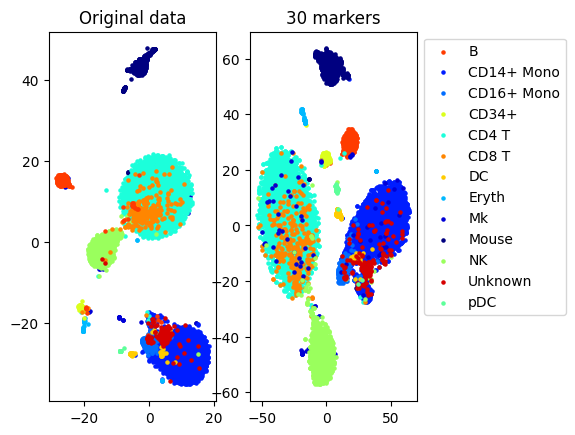

In [5]:
#TSNE plot
a=plot_marker_selection(data, markers, names)

## One vs all markers

In [8]:
markers2=one_vs_all_selection(data,labels)

accuracy=performance(data, labels, data, labels, clf)
accuracy_markers=performance(data[:,markers2], labels, data[:,markers2], labels, clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)

Accuracy (whole data, 500  markers):  0.8660786816757572
Accuracy (selected 50 markers) 0.7537426018335848


Computing TSNE embedding
Elapsed time: 75.1782386302948 seconds


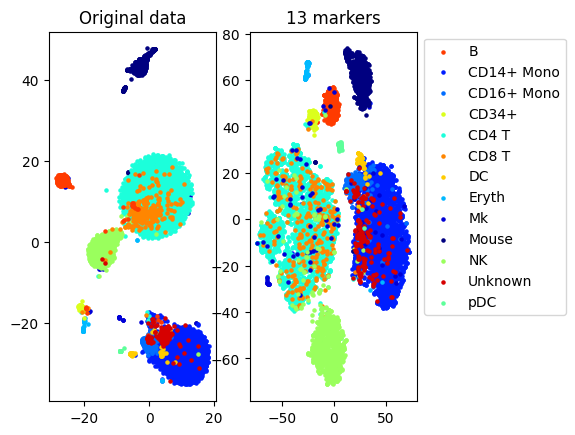

In [9]:
a=plot_marker_selection(data, markers2, names)

# Zeisel example
Zeisel data included in package, from

[2] Amit Zeisel, Ana B Munoz-Manchado, Simone Codeluppi, Peter Lonnerberg, Gioele La Manno, Anna Jureus, Sueli Marques, Hermany Munguba, Liqun He, Christer Betsholtz, et al. 
Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq. Science, 347(6226):1138–1142, 2015.

This example exhibits a hierarchical clustering structure. We use the function get_markers_hierarchy that takes the hierarchical structure into consideration to select the constraints.


In [10]:
#load data from file
[data, labels, names]=load_example_data("zeisel")
N,d=data.shape

## Use of scGeneFit (center based constraints)

In [11]:
num_markers=25
method='centers'
redundancy=0.1

markers= get_markers_hierarchy(data, labels, num_markers, method=method, redundancy=redundancy)

accuracy=performance(data, labels[0], data, labels[0], clf)
accuracy_markers=performance(data[:,markers], labels[0], data[:,markers], labels[0], clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)


Solving a linear program with 4000 variables and 94 constraints
Time elapsed: 0.3442702293395996 seconds
Accuracy (whole data, 4000  markers):  0.8745424292845257
Accuracy (selected 25 markers) 0.8948419301164725


In [12]:
#TSNE plot
a=plot_marker_selection(data, markers, names[0])

Computing TSNE embedding


## Use of scGeneFit (pairwise distance constraints)

In [ ]:
num_markers=25
method='pairwise'
sampling_rate=0.05 #use 5 percent of the data to generate constraints
n_neighbors=3 #3 constraints per point
epsilon=10 #Delta is 10*norm of the smallest constraint
max_constraints=500 #use at most 500 constraints (for efficiency)
use_centers=False #constraints given by pairwise distances

markers= get_markers_hierarchy(data, labels, num_markers, method=method, 
                     sampling_rate=sampling_rate, n_neighbors=n_neighbors, epsilon=epsilon)

accuracy=performance(data, labels[0], data, labels[0], clf)
accuracy_markers=performance(data[:,markers], labels[0], data[:,markers], labels[0], clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)


## Use of scGeneFit (pairwise center based constraints)

In [ ]:
num_markers=25
method='pairwise_centers'
sampling_rate=0.05 #use 5 percent of the data to generate constraints
n_neighbors=0 #neighbors are not used for the center constraints
epsilon=10 #Delta is 10*norm of the smallest constraint
max_constraints=500 #use at most 500 constraints (for efficiency)
use_centers=True #constraints given by pairwise distances

markers = get_markers_hierarchy(data, labels, num_markers, method=method, 
                     sampling_rate=sampling_rate, n_neighbors=n_neighbors, epsilon=epsilon)

accuracy=performance(data, labels[0], data, labels[0], clf)
accuracy_markers=performance(data[:,markers], labels[0], data[:,markers], labels[0], clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)

In [ ]:
#TSNE plot
a=plot_marker_selection(data, markers, names[0])

### Example from second level of the hierarchy

In [ ]:
for name in set(names[0]):
    idx=[s for s in range(len(names[0])) if names[0][s]==name]
    aux=plot_marker_selection(data[idx], markers, [names[1][s] for s in idx])

## One vs all markers

In [ ]:
markers2=one_vs_all_selection(data,labels[0])

accuracy=performance(data, labels[0], data, labels[0], clf)
accuracy_markers=performance(data[:,markers2], labels[0], data[:,markers2], labels[0], clf)

print("Accuracy (whole data,", d, " markers): ", accuracy)
print("Accuracy (selected", num_markers, "markers)", accuracy_markers)

In [ ]:
a=plot_marker_selection(data, markers2, names[0])